# BALTIC:
## the **B**ackronymed **A**daptable **L**ightweight **T**ree **I**mport **C**ode

--------------------

This notebook represents a collection of classes I've written over the last few years to parse, handle, analyse and visualise phylogenetic trees. Its humble origins lie with a [short linked list script on StackOverflow](http://stackoverflow.com/questions/280243/python-linked-list/280286#280286) and a lot of the machinery associated with it had been developed for my [2015 paper](https://mbe.oxfordjournals.org/content/32/1/162.full) on reassortment patterns in human influenza B virus. I've written the code to be fairly simple and highly adaptable, especially when it comes to tree visualisation. Versions of this code have been used to make fairly sophisticated figures, such as Fig 6 from my [MERS-CoV paper](http://ve.oxfordjournals.org/content/2/1/vev023):

<img src="https://d723wmguo58o1.cloudfront.net/content/vevolu/2/1/vev023/F6.large.jpg?width=800&height=600&carousel=1" 
alt="IMAGE ALT TEXT HERE" width="480" border="10" />

and an animation of Ebola virus spread in West Africa from an upcoming paper (click the image to see the video).

<a href="https://vimeo.com/156668942" target="_blank"><img src="https://i.vimeocdn.com/video/557748328.webp?mw=900&mh=546" 
alt="IMAGE ALT TEXT HERE" width="480" border="10" /></a>

---------------------
In order to correct [an article](http://science.sciencemag.org/content/348/6230/117) that got it wrong, I've rewritten some of the code recently to make the tree parser able to deal with polytomies, as well as being able to collapse branches with low support or short branch lengths. I've also implemented the ability to traverse subtrees under the same trait, which allows for the decomposition of labelled phylogenies into subtree spectra.

In this notebook you will find several examples of how the code can be used to plot [MCC trees]((https://github.com/evogytis/fluB/tree/master/data/mcc%20trees) from [my influenza B reassortment paper](https://mbe.oxfordjournals.org/content/32/1/162.full), as well as ways of converting trees into abstract graphs in time and trait space. I'm perfectly happy for people to use, modify and share my code as long as it's not being sold for personal profit. I would also appreciate any form of a nod wherever you use it, be it mentioning my name or maintaining the name BALTIC.

-------------
Gytis Dudas

21 Apr 2016

Fred Hutchinson Cancer Research Center


<a href="https://twitter.com/evogytis" target="_blank"><img style="float: left;" src="https://pbs.twimg.com/profile_images/647332202162823168/tVFGFWkm.jpg" 
alt="IMAGE ALT TEXT HERE" width="180" border="0" /></a>



In [1]:
from IPython.display import HTML
HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type">BALTIC</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://twitter.com/evogytis" property="cc:attributionName" rel="cc:attributionURL">Gytis Dudas</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/evogytis/BALTIC/blob/master/BALTIC_treeParser.ipynb" rel="dct:source">https://github.com/evogytis/BALTIC/blob/master/BALTIC_treeParser.ipynb</a>.')

## The classes
------------

There are 3 main classes in BALTIC:
- node = internal branches
- leaf = external branches
- tree = the entirety of the tree

The node and leaf classes are similar and share many parameters in common, such as branch length, height, position in absolute time, traits, parents, x and y coordinates and index of the character which defined them in the tree string. They differ in that the node class contains a list of its children objects for tree traversals, called children and a list of all tips that descend from it eventually, called leaves. Node class also contains parameters like childHeight and numChildren which are less important. The leaf class contains two name variable, numName and name. numName can be anything and is derived from the tree string itself. name can be set later and is meant to handle scenarios where the tree string contains tip names encoded as numbers, which can be decoded into name, rather than overwriting whatever was caught in numName.

The tree class wraps leaf and node classes together by performing operations to build, manipulate, visualise and analyse the full tree data structure. The recommended way of interacting with the tree is via the Objects list, which is a flat list of all branches in the tree.

## The function
------------

At the top is the make_tree function. Given a valid tree string and an empty tree object it will transform the information contained in the tree string into an actual tree data structure. If there are elements within the tree string that it can't parse it will warn the user of this. The most common reasons for this are unexpected characters in branch labels or something unexpected in tip names.

In [1]:
import re
import copy

class node: ## node class
    def __init__(self):
        self.length=0.0 ## branch length, recovered from string
        self.height=None ## height, set by traversing the tree, which adds up branch lengths along the way
        self.absoluteTime=None ## branch end point in absolute time, once calibrations are done
        self.parent=None ## reference to parent node of the node
        self.children=[] ## a list of descendent branches of this node
        self.traits={} ## dictionary that will contain annotations from the tree string, e.g. {'posterior':1.0}
        self.index=None ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
        self.childHeight=None ## the youngest descendant tip of this node
        self.numChildren=0 ## number of tips that are descended from this node
        self.x=None ## X and Y coordinates of this node, once drawTree() is called
        self.y=None
        ## contains references to all tips of this node
        self.leaves=[] ## is a sorted list of tips that are descended from it

class leaf: ## leaf class
    def __init__(self):
        self.name=None ## name of tip after translation, since BEAST trees will generally have numbers for taxa but will provide a map at the beginning of the file
        self.numName=None ## the original name of the taxon, would be an integer if coming from BEAST, otherwise can be actual name
        self.index=None ## index of the character that defines this object, will be a unique ID for each object in the tree
        self.length=None ## branch length
        self.absoluteTime=None ## position of tip in absolute time
        self.height=None ## height of tip
        self.parent=None ## parent
        self.traits={} ## trait dictionary
        self.x=None ## position of tip on x axis if the tip were to be plotted
        self.y=None ## position of tip on y axis if the tip were to be plotted

## tree class
class tree:
    def __init__(self):
        self.cur_node=node() ## current node is a new instance of a node class
        self.cur_node.index='Root' ## first object in the tree is the root to which the rest gets attached
        self.cur_node.length=0.0 ## startind node branch length is 0
        self.cur_node.height=0.0 ## starting node height is 0
        self.root=self.cur_node ## root of the tree is current node
        self.Objects=[] ## tree objects have a flat list of all branches in them
        self.treeHeight=0 ## tree height is the distance between the root and the most recent tip

    def add_node(self,i):
        """ attaches a new node to current node """
        new_node=node() ## new node instance
        new_node.index=i ## new node's index is the position along the tree string
        new_node.parent=self.cur_node ## new node's parent is current node
        self.cur_node.children.append(new_node) ## new node is a child of current node
        self.cur_node=new_node ## current node is now new node
        self.Objects.append(self.cur_node) ## add new node to list of objects in the tree
        
    def add_leaf(self,i,name):
        """ attaches a new leaf (tip) to current node """
        new_leaf=leaf() ## new instance of leaf object
        new_leaf.index=i ## index is position along tree string
        new_leaf.numName=name ## numName is the name tip has inside tree string, BEAST trees usually have numbers for tip names
        new_leaf.parent=self.cur_node ## leaf's parent is current node
        self.cur_node.children.append(new_leaf) ## assign leaf to parent's children
        self.cur_node=new_leaf ## current node is now new leaf
        self.Objects.append(self.cur_node) ## add leaf to all objects in the tree

    def setAbsoluteTime(self,date):
        """ place all objects in absolute time by providing the date of the most recent tip """
        
        for i in self.Objects: ## iterate over all objects
            i.absoluteTime=date-self.treeHeight+i.height ## heights are in units of time from the root

    def treeStats(self):
        """ provide information about the tree """
        self.traverse_tree() ## traverse the tree
        obs=self.Objects ## convenient list of all objects in the tree
        print '\nTree height: %.6f\nTree length: %.6f'%(self.treeHeight,sum([x.length for x in obs])) ## report the height and length of tree
        
        nodes=[x for x in obs if isinstance(x,node)] ## get all nodes
        strictlyBifurcating=False ## assume tree is not strictly bifurcating
        maxChildren=max([len(x.children) for x in nodes]) ## get the largest number of descendant branches of any node
        if maxChildren==2: ## if every node has at most two children branches
            strictlyBifurcating=True ## it's strictly bifurcating
        print '\nTree is strictly bifurcating = %s'%(strictlyBifurcating) ## report
        
        hasTraits=False ## assume tree has no annotations
        maxAnnotations=max([len(x.traits) for x in obs]) ## check the largest number of annotations any branch has
        if maxAnnotations>0: ## if it's more than 0
            hasTraits=True ## there are annotations
        print '\nTree has annotations = %s'%(hasTraits) ## report
        
        print '\nNumbers of objects in tree: %d (%d nodes and %d leaves)\n'%(len(obs),len(nodes),len(obs)-len(nodes)) ## report numbers of different objects in the tree
            
    def traverse_tree(self,startNode=None,include_all=False):
        """ Traverses tree from root. If a starting node is not defined begin traversal from root. By default returns a list of leaf objects that have been visited, optionally returns a list of all objects in the tree. """
        if startNode==None: ## if no starting point defined - start from root
            cur_node=self.root
            startNode=cur_node
        elif isinstance(startNode,leaf):
            return [startNode.numName]
        else:
            cur_node=startNode ## otherwise start from starting node
        
        seen=[] ## remember what's been visited
        collected=[] ## collect leaf objects along the way
        maxHeight=0 ## check what the maximum distance between the root and the most recent tip is
        height=0.0 ## begin at height 0.0
        root=False ## root becomes true once you're unable to go back any further

        while root==False: ## cycle indefinitely as long as there's more of the tree to explore
            if isinstance(cur_node,node): ## if currently dealing with a node
                if include_all==True and cur_node not in collected: ## if node hasn't been collected and we want to collect all objects - add it for reporting later
                    collected.append(cur_node)
                ## check whether all children of the node have been seen or whether we're not currently at the root
                ## as long as all children have been seen will descend downwards
                while sum([1 if x.index in seen else 0 for x in cur_node.children])==len(cur_node.children) and cur_node!=startNode:
                    ## check wheteher current node's most recent child is higher than the known highest point in the tree
                    if cur_node.childHeight <= highestTip:
                        cur_node.childHeight = highestTip
                    elif cur_node.childHeight > highestTip:
                        highestTip = cur_node.childHeight
                    
                    if cur_node.parent.index==startNode.index: ## if currently at root - set the root flag to True and break the while loop
                        cur_node.height=height
                        root=True
                        break
                    else: ## otherwise...
                        cur_node.parent.numChildren+=cur_node.numChildren ## add the number of current node's children to its parent
                        cur_node.parent.leaves+=cur_node.leaves ## add the list of tip names descended from current node to its parent
                        cur_node.parent.leaves=unique(cur_node.parent.leaves) ## reduce to only unique names
                        cur_node.parent.leaves=sorted(cur_node.parent.leaves) ## sort children
                        cur_node.height=height ## set height
                        height-=float(cur_node.length) ## prepare height value for the eventual descent downwards in the tree
                        cur_node=cur_node.parent ## current node is now current node's parent

                last_seen=[1 if x.index in seen else 0 for x in cur_node.children] ## put 1 for every child of the node that you have seen, 0 for every one that hasn't been seen
                
                try: ## try finding the first unvisited child of a node
                    idx_to_visit=last_seen.index(0)
                except ValueError:
                    idx_to_visit=0 ## no children seen yet
                
                cur_node.height=height ## set height of current node
                height+=float(cur_node.children[idx_to_visit].length) ## prepare for heading towards the previously unvisited child branch
                cur_node=cur_node.children[idx_to_visit] ## set current node to unvisited child
                seen.append(cur_node.index) ## remember that the child has now been visited
                
            elif isinstance(cur_node,leaf): ## node dealing with node, are we dealing with a leaf (tip)?
                cur_node.parent.numChildren+=1 ## parent has one more new child (congratulations!)
                cur_node.parent.leaves.append(cur_node.numName) ## add the name of leaf to its parent's list of children names
                cur_node.parent.leaves=sorted(cur_node.parent.leaves) ## sort parent's children list
                seen.append(cur_node.index) ## leaf has now officially been seen
                highestTip=float(height) ## set the height of the leaf as being potentially the highest tip
                cur_node.height=height ## set leaf's height
                
                if cur_node not in collected: ## if leaf hasn't been collected - add it for reporting later
                    collected.append(cur_node)
                if maxHeight<=float(cur_node.height): ## is this the highest point we've seen in the tree so far?
                    maxHeight=float(cur_node.height)
                    
                height-=float(cur_node.length) ## prepare for heading back
                cur_node=cur_node.parent ## current node is now leaf's parent
                
        self.treeHeight=float(maxHeight) ## tree height of this tree is the height of the highest tip
        return collected ## return a list of collected leaf objects

    def renameTips(self,d):
        """ give each tip its correct label using a dictionary """
        for k in self.Objects: ## iterate through objects in tree
            if isinstance(k,leaf): ## if it's leaf
                k.name=d[k.numName] ## change its name
    
    def sortBranches(self,descending=True):
        """ sort descendants of each node """
        if descending==True:
            modifier=1 ## define the modifier for sorting function later
        elif descending==False:
            modifier=-1

        for k in self.Objects: ## iterate over objects
            if isinstance(k,node): ## only interested in nodes
                ## split node's offspring into nodes and leaves, sort each list individually
                nodes=sorted([x for x in k.children if isinstance(x,node)],key=lambda q:(-len(q.leaves)*modifier,q.length*modifier))
                leaves=sorted([x for x in k.children if isinstance(x,leaf)],key=lambda q:q.length*modifier)
                
                if modifier==1: ## if sorting one way - nodes come first, leaves later
                    k.children=nodes+leaves
                elif modifier==-1: ## otherwise sort the other way
                    k.children=leaves+nodes
                    
        self.drawTree() ## update x and y positions of each branch, since y positions will have changed because of sorting
        
    def drawTree(self):
        """ find x and y coordinates of each branch """
        order=[x.numName for x in self.traverse_tree() if isinstance(x,leaf)] ## order is a list of tips recovered from a tree traversal to make sure they're plotted in the correct order along the vertical tree dimension
        
        for k in self.Objects: ## reset coordinates for all objects
            k.x=None
            k.y=None
        
        storePlotted=0
        drawn=[] ## drawn keeps track of what's been drawn
        while len(drawn)!=len(self.Objects): # keep drawing the tree until everything is drawn
            for k in [x for x in self.Objects if x.index not in drawn]: ## iterate through objects that have not been drawn
                if isinstance(k,leaf): ## if leaf - get position of leaf, draw branch connecting tip to parent node
                    x=k.height ## x position is height
                    y=order.index(k.numName) ## y position of leaf is given by the order in which tips were visited during the traversal
                    k.x=x ## set x and y coordinates
                    k.y=y
                    drawn.append(k.index) ## remember that this objects has been drawn

                if isinstance(k,node): ## if parent is non-root node and y positions of all its children are known
                    if len([q.y for q in k.children if q.y!=None])==len(k.children):
                        x=k.height ## x position is height              
                        children_y_coords=[q.y for q in k.children if q.y!=None] ## get all existing y coordinates of the node
                        y=sum(children_y_coords)/float(len(children_y_coords)) ## internal branch is in the middle of the vertical bar
                        k.x=x
                        k.y=y
                        drawn.append(k.index) ## remember that this objects has been drawn
                        
            assert len(drawn)>storePlotted,'Got stuck trying to find y positions of objects'
            storePlotted=len(drawn)

    def traverseWithinTrait(self,startNode,traitName,converterDict=None):
        """ Traverse the tree staying within a particular trait value """
        cur_node=startNode
        seen=[]
        collected=[]

        if converterDict==None: ## no dictionary to convert trait values, trying to stay inside trait value of starting node
            stayWithin=startNode.traits[traitName]
        else: ## there's a dictionary, trying to stay within same dictionary value
            stayWithin=converterDict[startNode.traits[traitName]]
 
        root=False
        
        if isinstance(startNode,leaf): ## quite immediatelly if starting from a leaf - nowhere to go
            collected.append(startNode)
            return collected

        while root==False:
            if isinstance(cur_node,node):
                ## if all children have been seen and not at root
                while sum([1 if child.index in seen else 0 for child in cur_node.children])==len(cur_node.children) and cur_node.parent!=self.root:
                    if converterDict==None: ## if about to traverse into different trait state - break while loop
                        curTrait=cur_node.traits[traitName]
                    else:
                        curTrait=converterDict[cur_node.traits[traitName]]
                    
                    if curTrait!=stayWithin:
                        root=True
                        return collected

                    if cur_node.index==startNode.index or cur_node.index=='Root': ## if back at starting node or the root - break while loop
                        root=True
                        return collected
                        
                    else: ## otherwise keep heading backwards
                        cur_node=cur_node.parent
                
                seen.append(cur_node.index) ## current node seen
                
                if cur_node not in collected: ## add current node to collection
                    collected.append(cur_node)
                
                for child in cur_node.children: ## iterate over children
                    if converterDict==None:
                        childTrait=child.traits[traitName]
                    else:
                        childTrait=converterDict[child.traits[traitName]]
                    
                    if childTrait!=stayWithin: ## if child trait not what is wanted - pretend it's been visited
                        seen.append(child.index)
                
                ## 1 if child was seen, otherwise 0
                ## 0 indicates that child wasn't explored
                last_seen=[1 if child.index in seen else 0 for child in cur_node.children]
                
                if 0 in last_seen: ## if some of the children unseen - go to them
                    idx_to_visit=last_seen.index(0)
                    cur_node=cur_node.children[idx_to_visit]
                else: ## otherwise head back, nothing to see any more
                    cur_node=cur_node.parent
                
            elif isinstance(cur_node,leaf):
                seen.append(cur_node.index)

                if cur_node not in collected:
                    collected.append(cur_node)
                
                if cur_node.index==startNode.index or cur_node.parent.index=='Root': ## if back at starting node or the root - break while loop
                    root=True
                    return collected
                else:
                    cur_node=cur_node.parent
            
    def collapseNodes(self,trait,cutoff):
        """ Collapse all nodes whose trait value is below the cutoff value """
        newTree=copy.deepcopy(self) ## work on a copy of the tree
        nodes=[x for x in newTree.Objects if isinstance(x,node)] ## fetch a list of all nodes
        zero_count=sum([1 if q.traits[trait]<cutoff else 0 for q in nodes]) ## count how many branches fail the test

        assert zero_count<len(nodes),'Chosen cutoff would remove all branches'
        
        while zero_count>0: ## as long as there are branches to be collapsed - keep reducing the tree
            for k in sorted(nodes,key=lambda x:x.height): ## start with branches near the tips
                if k.traits[trait]<=cutoff: ## if trait value is less than cutoff - remove it cleanly
                    zero_node=k.children ## fetch the node's children
                    k.parent.children+=zero_node ## add them to the zero node's parent
                    
                    old_parent=k ## node to be deleted is the old parent
                    new_parent=k.parent ## once node is deleted, the parent to all their children will be the parent of the deleted node
                    
                    for w in newTree.Objects: ## assign the parent of zero node as the parent to any children of zero node
                        if w.parent==old_parent:
                            w.parent=new_parent
                            w.length+=old_parent.length

                    k.parent.children.remove(k) ## remove traces of zero node - it doesn't exist as a child, doesn't exist in the tree and doesn't exist in the nodes list
                    newTree.Objects.remove(k)
                    nodes.remove(k)

                    zero_count-=1 ## one more zero node taken care of
        return newTree ## return collapsed tree
    
    def toString(self):
        """ Output the topology of the tree with branch lengths to string """
        cur_node=self.root
        seen=[]
        tree_string=[]
        root=False

        while root==False:
            if isinstance(cur_node,node):
                ## if all children have been seen and not at root
                while sum([1 if x.index in seen else 0 for x in cur_node.children])==len(cur_node.children) and cur_node!=self.root:
                    if cur_node.parent.index=='Root':
                        root=True
                        break
                    else:
                        tree_string.append('):%8f'%(cur_node.length)) ## end of node, add branch length
                        cur_node=cur_node.parent ## go back
                        
                seen.append(cur_node.index)
                last_seen=[1 if x.index in seen else 0 for x in cur_node.children]
                
                if 0 in last_seen: ## there's unvisited children
                    idx_to_visit=last_seen.index(0)
                    if idx_to_visit>0: ## first child definitely seen, so visiting the second child at the very least
                        tree_string.append(',') ## add comma to indicate bifurcation
                    cur_node=cur_node.children[idx_to_visit]
                    
                    if isinstance(cur_node,node):
                        tree_string.append('(') ## dealing with new node, add (
                    else:
                        tree_string.append('\'%s\':%8f'%(cur_node.name,cur_node.length)) ## dealing with tip, write out name, add branch length
                    
                else: ## all children seen, clade's end
                    tree_string.append('):%8f'%(cur_node.length))
                    cur_node=cur_node.parent
                
            elif isinstance(cur_node,leaf):
                seen.append(cur_node.index)
                if cur_node.parent.index=='Root':
                    root=True
                    break
                else:
                    cur_node=cur_node.parent
                
        return ''.join(tree_string)+';' ## the coup de grace
                        
def make_tree(data,ll):
    """
    data is a tree string, ll (LL) is an instance of a tree object
    """
    i=0 ## is an adjustable index along the tree string, it is incremented to advance through the string
    stored_i=None ## store the i at the end of the loop, to make sure we haven't gotten stuck somewhere in an infinite loop
    
    while i < len(data): ## while there's characters left in the tree string - loop away
        assert (stored_i != i),'\nTree string unparseable\nStopped at >>%s<<\nstring region looks like this: %s'%(data[i],data[i:i+2000]) ## make sure that you've actually parsed something last time, if not - there's something unexpected in the tree string
        stored_i=i ## store i for later
        
        if data[i] == '(': ## look for new nodes
            ll.add_node(i) ## add node to current node in tree ll
            i+=1 ## advance in tree string by one character
            
        cerberus=re.match('([0-9]+)\[',data[i:i+250]) ## look for tips in BEAST format (integers).
        if cerberus is not None:
            ll.add_leaf(i,cerberus.group(1)) ## add tip
            i+=len(cerberus.group(1)) ## advance in tree string by however many characters the tip is encoded
            
        cerberus=re.match('(\'|\"|)([A-Za-z\_\-\|\.0-9\?\/]+)(\'|\"|)(\[)*',data[i:i+1000])  ## look for tips with unencoded names - if the tips have some unusual format you'll have to modify this
        if cerberus is not None:
            ll.add_leaf(i,cerberus.group(2))  ## add tip
            i+=len(cerberus.group(2))+cerberus.group().count("'")+cerberus.group().count('"') ## advance in tree string by however many characters the tip is encoded
            
        cerberus=re.match('\[&[A-Za-z\_\-{}\,0-9\.\%=\"]+\]',data[i:i+5000])## look for MCC comments
        if cerberus is not None:
            comment=cerberus.group()
            numerics=re.findall('[A-Za-z\_\.0-9]+=[0-9\-Ee\.]+',comment) ## find all entries that have values as floats
            strings=re.findall('[A-Za-z\_\.0-9]+="[A-Za-z\_]+"',comment) ## find all entries that have values as strings
            ## ranges not included - who needs those anyway?
            
            for vals in numerics: ## assign all parsed annotations to traits of current branch
                tr,val=vals.split('=') ## split each value by =, left side is name, right side is value
                ll.cur_node.traits[tr]=float(val)

            for vals in strings:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=val.strip('"')
            
            i+=len(comment) ## advance in tree string by however many characters it took to encode labels
            
        microcerberus=re.match('\:([0-9\.\-Ee]+)',data[i:i+1000]) ## look for branch lengths without comments
        if microcerberus is not None:
            ll.cur_node.length=float(microcerberus.group(1)) ## set branch length of current node
            i+=len(microcerberus.group()) ## advance in tree string by however many characters it took to encode branch length
            
        microcerberus=re.match('\:\[&([A-Za-z\_\-{}\,0-9\.\%=\"]+)\]([0-9\.\-Ee]+)',data[i:i+5000]) ## look for branch lengths under BEAST formatting, which includes annotations
        if microcerberus is not None:
            comment=microcerberus.group(1)
            numerics=re.findall('[A-Za-z\_\.0-9]+=[0-9\-Ee\.]+',comment)
            strings=re.findall('[A-Za-z\_\.0-9]+="[A-Za-z\_]+"',comment)
            
            for vals in numerics:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=float(val)
                
            for vals in strings:
                tr,val=vals.split('=')
                ll.cur_node.traits[tr]=val.strip('"')
            
            ll.cur_node.length=float(microcerberus.group(2))
            i+=len(microcerberus.group())

        if data[i] == ',': ## look for bifurcations
            i+=1 ## advance in tree string
            ll.cur_node=ll.cur_node.parent ## next object will be a descendant of current node's parent - go to parent
            
        if data[i] == ')': ## look for clade ends
            ll.cur_node=ll.cur_node.parent ## nothing to be done for current node - it's done, so head back to parent
            i+=1 ## advance in tree string

        if data[i] == ';': ## look for string end
            break ## end loop

## Tree import
-----------
I haven't dedicated much time to writing a general tree parser to handle all cases, but the example below shows how to handle a simple FigTree file. If other formats are required, such as newick, it should be as easy as handing the make_tree function the tree string and an empty tree object.

In [2]:
import datetime as dt
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def unique(o, idfun=repr):
    """Reduce a list down to its unique elements."""
    seen = {}
    return [seen.setdefault(idfun(e),e) for e in o if idfun(e) not in seen]

def decimalDate(date,fmt="%Y-%m-%d",variable=False,dateSplitter='-'):
    """ Converts calendar dates in specified format to decimal date. """
    if variable==True: ## if date is variable - extract what is available
        dateL=len(date.split(dateSplitter))
        if dateL==2:
            fmt=dateSplitter.join(fmt.split(dateSplitter)[:-1])
        elif dateL==1:
            fmt=dateSplitter.join(fmt.split(dateSplitter)[:-2])
        
    adatetime=dt.datetime.strptime(date,fmt) ## convert to datetime object
    year = adatetime.year ## get year
    boy = dt.datetime(year, 1, 1) ## get beginning of the year
    eoy = dt.datetime(year + 1, 1, 1) ## get beginning of next year
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds())) ## return fractional year

tree_path='/Users/evogytis/Documents/fluB/data/mcc trees/InfB_NPt_ALLs1.mcc.tre' ## define path to (in this case) FigTree file
print "File: %s"%(tree_path.split('/')[-1])
tipFlag=False ## used to keep track of where we are in FigTree format
tips={} ## dictionary of tip code to full tip name

for line in open(tree_path,'r'): ## iterate through FigTree lines
    l=line.strip('\n') ## strip newline characters from each line

    cerberus=re.search('dimensions ntax=([0-9]+);',l.lower()) ## check how many tips there are supposed to be
    if cerberus is not None:
        tipNum=int(cerberus.group(1))

    cerberus=re.search('tree TREE([0-9]+) = \[&R\]',l) ## search for beginning of tree string in BEAST format
    if cerberus is not None:
        treeString_start=l.index('(') ## tree string starts where the first '(' is in the line
        ll=tree() ## new instance of tree
        make_tree(l[treeString_start:],ll) ## send tree string to make_tree function, provide an empty tree object

    if tipFlag==True:
        cerberus=re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',l) ## look for tip name map, where each tip is given an integer to represent it in tree
        if cerberus is not None:
            tips[cerberus.group(1)]=cerberus.group(2).strip("'") ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in l: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',l.replace('\t','')

    if 'translate' in l.lower(): ## start looking for tips
        tipFlag=True
    if ';' in l: ## stop looking for tips
        tipFlag=False

print "Number of objects found in tree string: %d"%(len(ll.Objects))

## rename tips, find the highest tip (in absolute time) in the tree
if len(tips)==0: ## use this if tip names in the string are already the final format
    for k in ll.Objects:
        if isinstance(k,leaf):
            k.name=k.numName
    highestTip=max([decimalDate(x.name.strip("'").split('_')[-1],variable=True) for x in ll.Objects if isinstance(x,leaf)])
else: ## there's a tip name map at the beginning, so translate the names
    ll.renameTips(tips) ## give each tip a name
    highestTip=max([decimalDate(x.strip("'").split('_')[-1],variable=True) for x in tips.values()])

ll.treeStats() ## report tree stats (also traverses tree), otherwise need to call ll.traverse_tree()
ll.sortBranches() ## sort the branches, automatically draws tree, otherwise need to call ll.drawTree()

## set absolute time knowing *when* the most recent tip is in absolute time
ll.setAbsoluteTime(highestTip)
print 'Highest tip date: %.4f'%(highestTip)

print 'Done!'

File: InfB_NPt_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 29.430115
Tree length: 451.887106

Tree is strictly bifurcating = True

Tree has annotations = True

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Highest tip date: 2012.1530
Done!


## Plotting trees
-----------
As long as the drawTree() function has been called from the tree object it's possible to draw out the tree by iterating over every branch in the tree object and plotting it. It remains up to the user as to how the tree gets plotted in terms of colour, branch width, tip sizes, tip labels, etc.

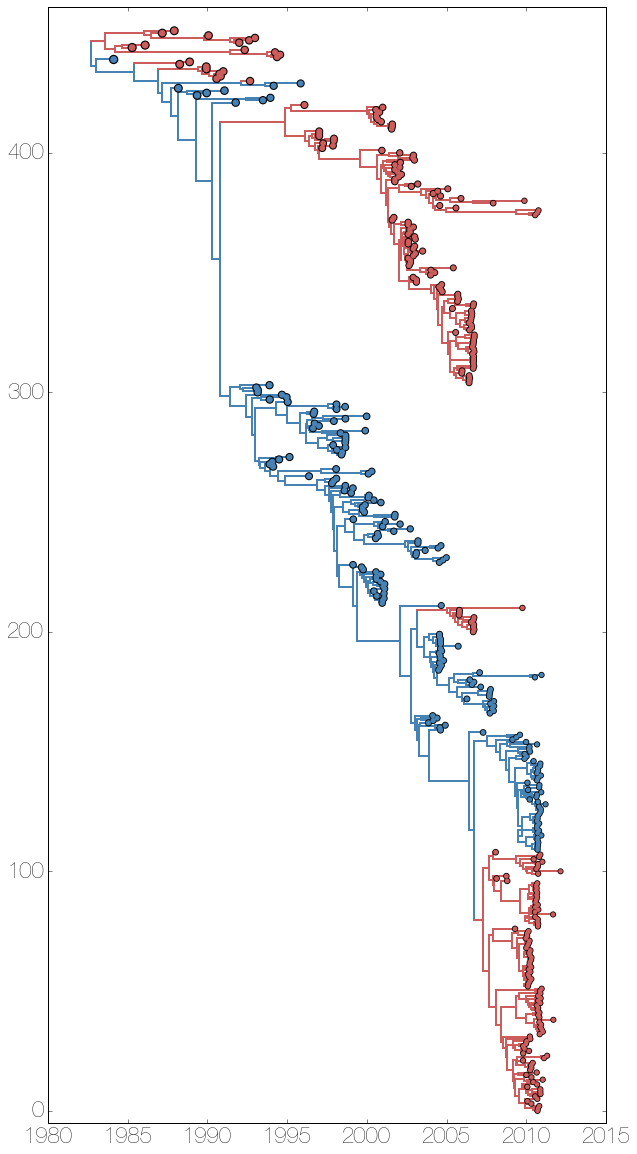

In [3]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis

for k in ll.Objects: ## iterate over objects in tree
#     x=k.x ## or from x position determined earlier
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
#     xp=k.parent.x ## get x position of current object's parent
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

#     c='indianred' ## colour can be fixed
#     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
#     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
    c=['indianred' if k.traits['PB1']=='V' else 'steelblue'][0] ## can be discrete too
    
    if isinstance(k,leaf): ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=50 ## tip size can be fixed
        s=50-30*k.height/ll.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,node): ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
ax.set_ylim(-5,len(ll.Objects)/2+10)
plt.show()

## Collapsing trees
------
Trees can be collapsed by removing branches with a trait value that is less than a specified cutoff. The returned tree object then needs to be redrawn using the drawTree() method to get new y positions for branches.

903 644


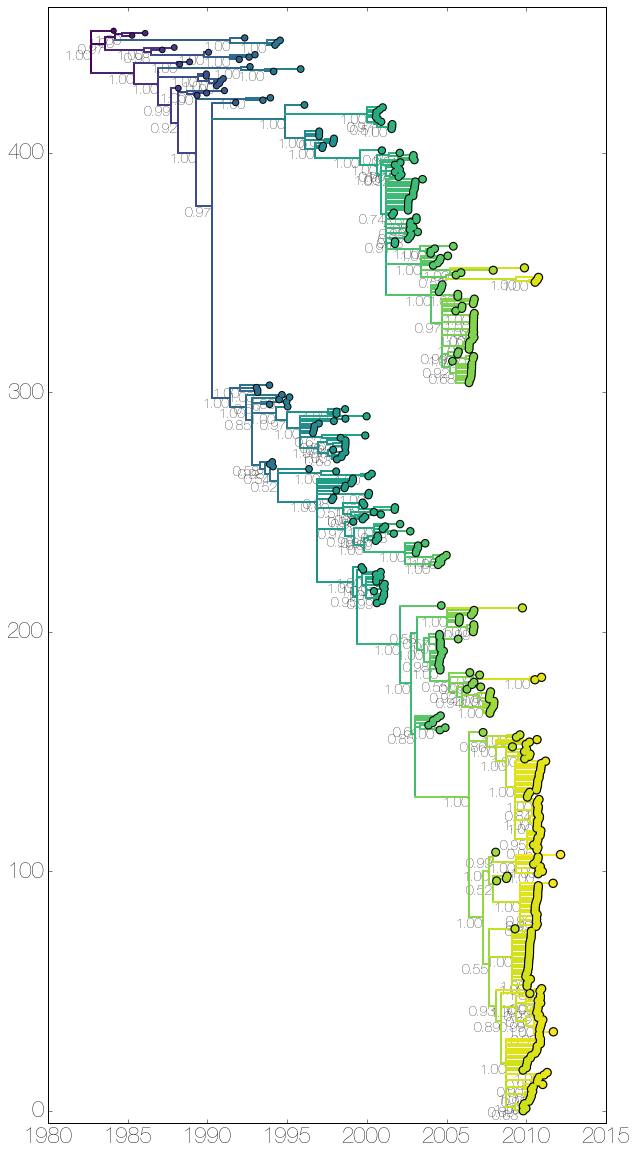

In [4]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis

cc=ll.collapseNodes('posterior',0.5) ## collapse branches below 0.5 posterior probability
cc.sortBranches() ## sort branches, also redraws tree

print len(ll.Objects),len(cc.Objects) ## check how many branches were collapsed

for k in cc.Objects: ## iterate over objects in tree
#     x=k.x ## or from x position determined earlier
    x=k.absoluteTime ## absolute time on the x, rather than height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
#     xp=k.parent.x ## get x position of current object's parent
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

#     c='indianred' ## colour can be fixed
    c=cmap(k.height/ll.treeHeight) ## or be a function of something else
#     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
#     c=['indianred' if k.traits['PB1']=='V' else 'steelblue'][0] ## can be discrete too
    
    if isinstance(k,leaf): ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=50 ## tip size can be fixed
        s=20+30*k.height/ll.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,node): ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot vertical bar
        ax.text(x,y,'%.2f'%(k.traits['posterior']),va='top',ha='right',size=14) ## plot posterior values at each node

    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot actual branch (horizontal)
        
ax.set_ylim(-5,len(ll.Objects)/2+10)
plt.show()

## Extract trait subtrees, fix subtrees
-------
The following cell showcases code to decompose trees with trait labels into individual subtrees, which are recovered from within-trait tree traversals. Occasionally it means ending up with nodes with only one valid child, which needs to be fixed.

Both children within the same trait: True (Y,V)
removing: 0, children in: ['Y', 'V']
existed at time 1982.7229, with branch length 0.0000
removing: 2213, children in: ['Y', 'V']
existed at time 1985.4112, with branch length 2.4191
removing: 2214, children in: ['Y', 'V']
existed at time 1986.9341, with branch length 3.9420
removing: 47237, children in: ['Y', 'V']
existed at time 1990.7612, with branch length 0.4557
removing: 26601, children in: ['Y', 'V']
existed at time 1992.0974, with branch length 4.9690
removing: 973317, children in: ['Y', 'V']
existed at time 2003.1504, with branch length 0.3855
removing: 263966, children in: ['V', 'Y']
existed at time 2006.7127, with branch length 0.2938


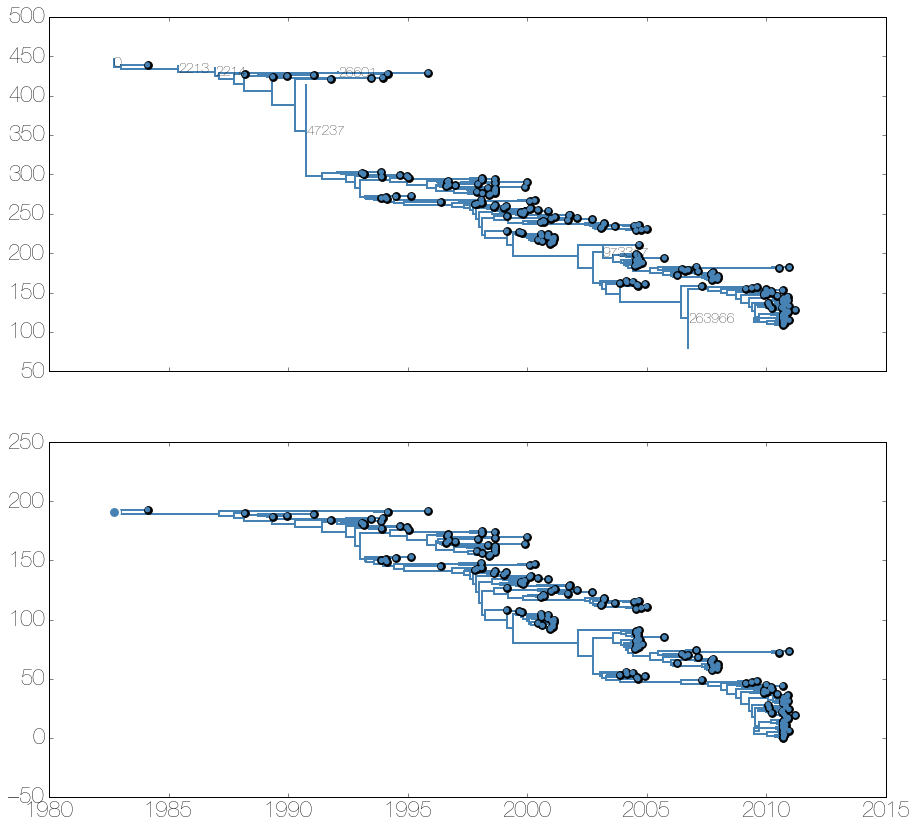

Both children within the same trait: True (V,V)


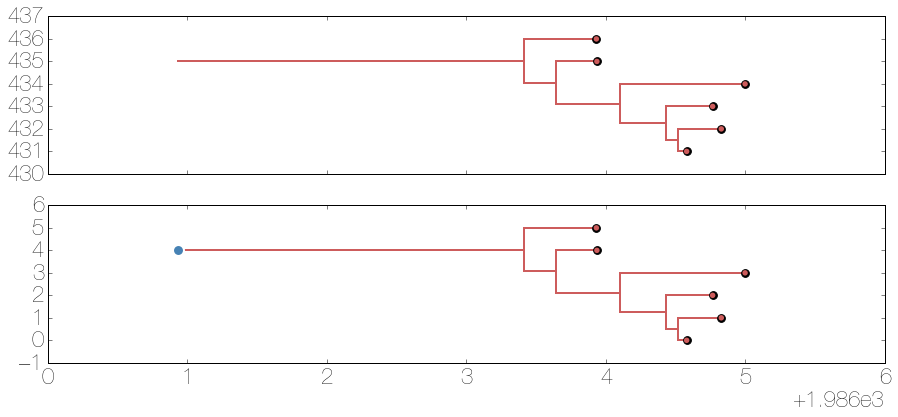

Ignoring tip B/Hong_Kong/02/1993_1993-02-15
Both children within the same trait: True (V,V)


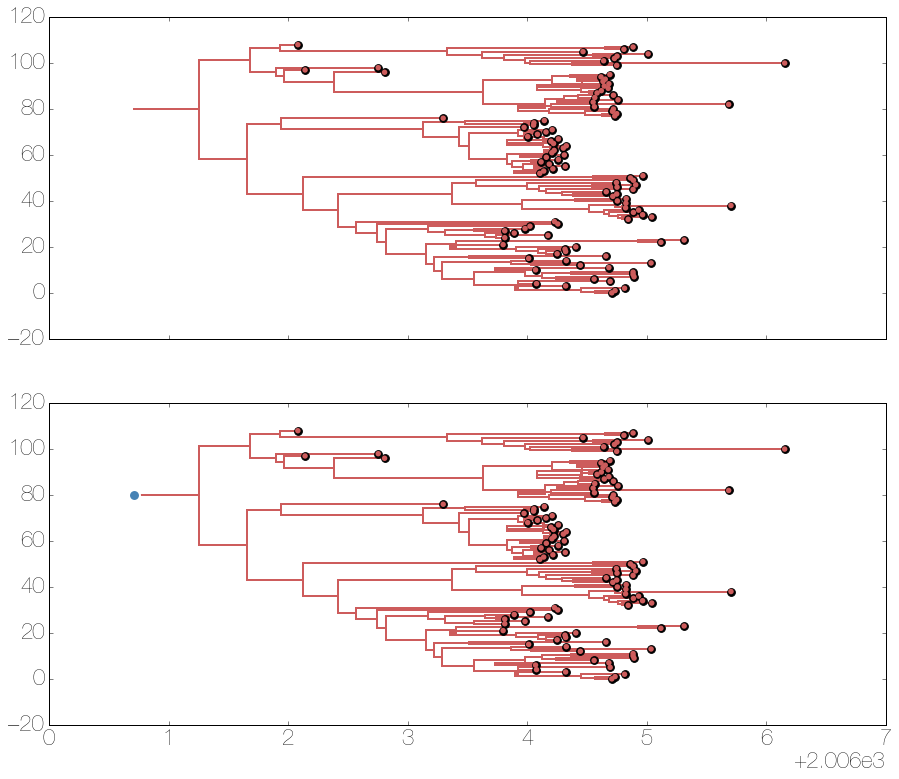

Both children within the same trait: True (V,V)


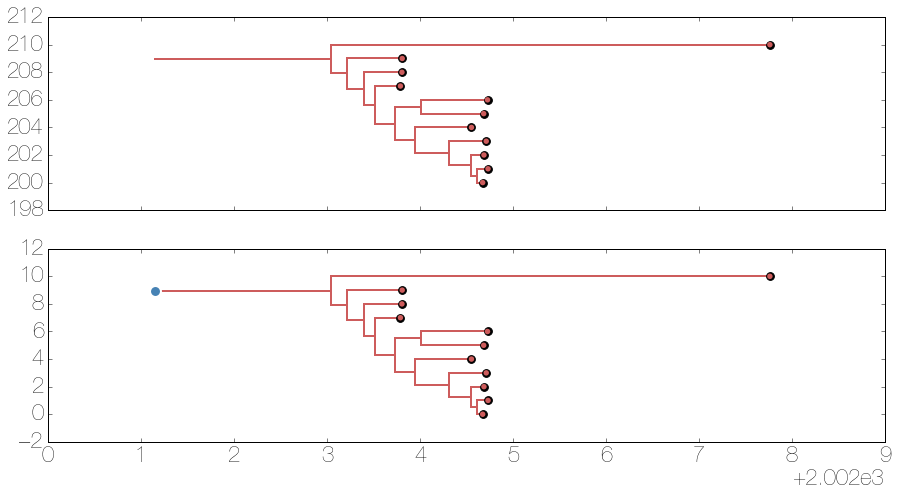

Both children within the same trait: True (V,V)


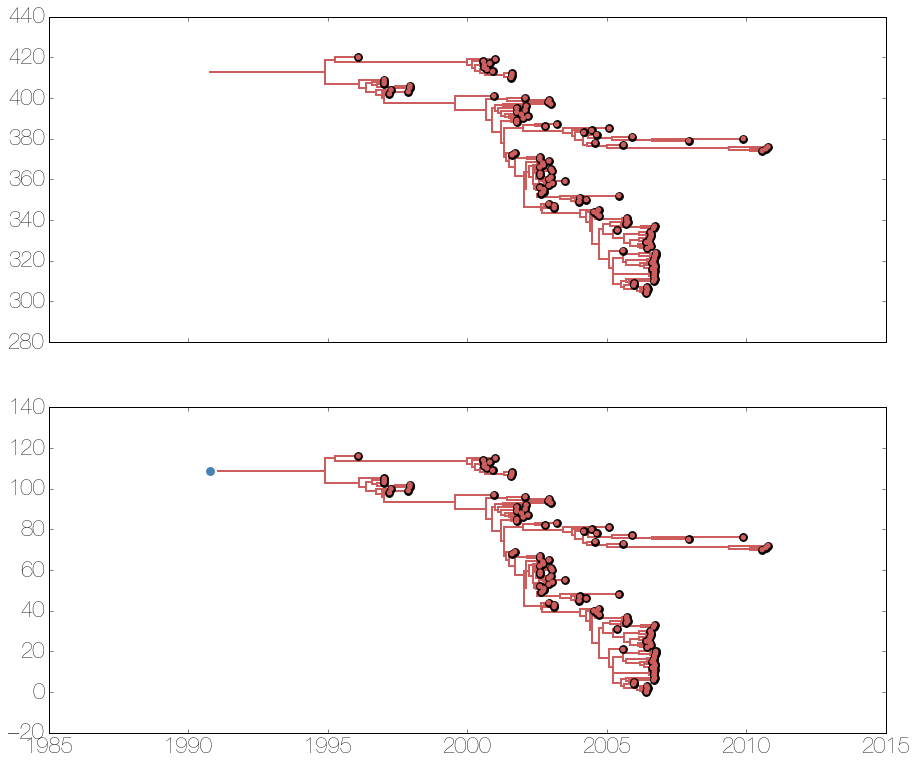

Both children within the same trait: True (V,V)


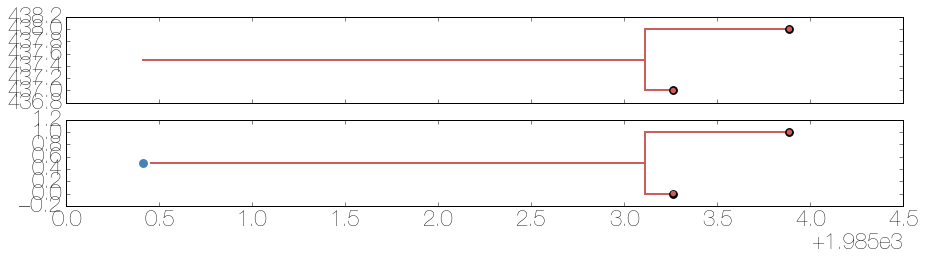

Both children within the same trait: True (V,V)


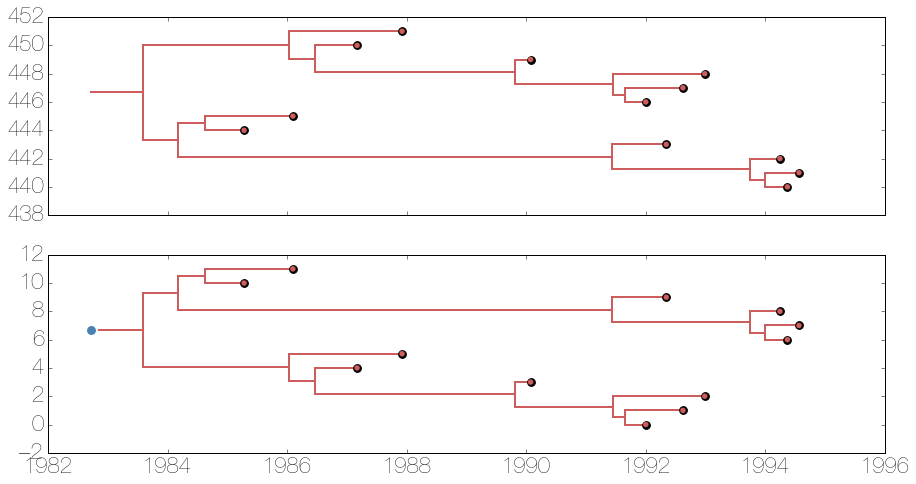

Done!


In [6]:
traitName='PB1'
branchWidth=2
tipSize=30

import numpy as np

ll.root.traits[traitName]='ancestor' ## add fake trait to root of the tree

tree_strings={'Y':[],'V':[],'ancestor':[]}
subtype_trees={'Y':[],'V':[],'ancestor':[]}

for l in ll.Objects:
    k=l
    kp=l.parent
    
    ## get current node's country and its parent's country
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName):
        kploc=kp.traits[traitName]
        kpc=kploc
    else:
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc
    
    ## if countries don't match and there's at least the potential for 2 leaves (smallest viable tree)
    if kc!=kpc:
        proceed=False
        
        ## if dealing with a leaf - proceed
        if isinstance(k,leaf):
            N_children=1
            proceed=False
            print 'Ignoring tip %s'%(k.name)
        else:
            N_children=len(k.leaves)
            ## check if both children of node are in the same location - proceed only if they are
            if [ch.traits[traitName] for ch in k.children].count(kc)>0:
                proceed=True
                
            print 'Both children within the same trait: %s (%s)'%(proceed,','.join([ch.traits[traitName] for ch in k.children]))

        ## subtree is a deep-copied list of objects traversed from a node that switched traits, as long as traversal is taking place within the same trait
        if proceed==True:
            subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName))
            #subtree.append(k.parent)
            subtree_leaves=[x.numName for x in subtree if isinstance(x,leaf)]
            
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(15,1+np.log10(len(subtree))*5),squeeze=True) ## start bi-plot with a shared x axis

#             node_times=[w.absoluteTime for w in subtree if w.absoluteTime!=None]
#             node_times+=[subtree[0].absoluteTime-subtree[0].length]
#             node_ys=[w.y for w in subtree]
            
            ## plot uncorrected subtree in first subplot
            for w in subtree:
                c=['indianred' if w.traits[traitName]=='V' else 'steelblue'][0]

                y=w.y
                x=w.absoluteTime

                ## the root of the complete tree has no parent
                if w.parent==None:
                    xp=w.absoluteTime
                    yp=w.y
                else:
                    xp=w.parent.absoluteTime
                    yp=w.parent.y

                if isinstance(w,leaf):
                    ax1.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                    ax1.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=99)

                elif isinstance(w,node):
                    yl=w.children[0].y
                    yr=w.children[-1].y

                    ax1.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

                    if sum([1 if ch in subtree else 0 for ch in w.children])<len(w.children):
                        ax1.text(x+0.001,y,'%d'%(w.index),va='center',ha='left',size=14,zorder=1000)
                
                ax1.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot branch
                
            ## as long as there are nodes with children that are not entirely within subtree - keep removing nodes
            while sum([len(nd.children)-sum([1 if ch in subtree else 0 for ch in nd.children]) for nd in subtree if isinstance(nd,node) and nd.index!='Root'])>0: ## as long as there are nodes with invalid children numbers keep looping
                for nd in sorted([q for q in subtree if isinstance(q,node)],key=lambda x:(sum([1 if ch in subtree else 0 for ch in x.children]),x.height)): ## iterate over nodes according to how many of their children are missing from the subtree and their height
                    
                    child_status=[1 if ch in subtree else 0 for ch in nd.children] ## check how many valid children the node has in subtree
                    
                    if sum(child_status)<2 and nd.index!='Root': ## if less than 2 children in subtree (i.e. not all children are under the same trait state)
                        print 'removing: %d, children in: %s'%(nd.index,[ch.traits[traitName] for ch in nd.children])
                        print 'existed at time %.4f, with branch length %.4f'%(nd.absoluteTime,nd.length)
                        grand_parent=nd.parent ## grandparent is invalid node's parent
                        grand_parent.children.remove(nd) ## remove invalid node from grandparent's children

                        if sum(child_status)==0:
                            pass
                        else:
                            ## disconnect current node from its 1 valid child and parent, connect child with parent of current node
                            child=nd.children[child_status.index(1)] ## child that will remain is the first valid child
                            child.parent=grand_parent ## child's grandparent is now parent
                            grand_parent.children.append(child) ## child is now child of grandparent
                            child.length+=nd.length ## adjust child's branch length
                            
                        subtree.remove(nd) ## remove child from list of objects in subtree
                        
            local_tree=tree() ## create a new tree object where the subtree will be
            local_tree.Objects=subtree ## assign objects
            
            ## connect objects with the root
            local_tree.root.children.append(subtree[0])
            subtree[0].parent=local_tree.root
            local_tree.root.absoluteTime=subtree[0].absoluteTime-subtree[0].length
            local_tree.sortBranches() ## sort branches, draw small tree
            
            local_tree.root.x=local_tree.Objects[0].x
            local_tree.root.y=local_tree.Objects[0].y
            
            ## remember subtree string, subtree object itself
            tree_strings[kc].append(local_tree.toString())
            subtype_trees[kc].append((kpc,local_tree))
            
            oriC=['indianred' if kpc=='V' else 'steelblue'][0] ## get colour of the (sub)tree's origin
            if local_tree.Objects[0].absoluteTime==None:
                oriX=local_tree.Objects[0].absoluteTime
                oriY=local_tree.Objects[0].y
            else:
                oriX=local_tree.Objects[0].parent.absoluteTime
                oriY=local_tree.Objects[0].y
            
            ## plot circle at the base of each subtree
            ax2.scatter(oriX,oriY,120,facecolor=oriC,edgecolor='w',lw=2,zorder=200)

            #node_times=[w.absoluteTime for w in subtree if w.absoluteTime!=None]
            #node_times+=[subtree[0].absoluteTime-subtree[0].length]
            #node_ys=[w.y for w in subtree]
            
            for w in subtree: ## plot fixed subtree onto secondary plot
                c=['indianred' if w.traits[traitName]=='V' else 'steelblue'][0]
                y=w.y
                x=w.absoluteTime

                ## the root of the complete tree has no parent
                if w.parent==None:
                    xp=w.absoluteTime
                    yp=w.y
                else:
                    xp=w.parent.absoluteTime
                    yp=w.parent.y
                
                if isinstance(w,leaf):
                    ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## plot tip circle
                    ax2.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=99)

                elif isinstance(w,node):
                    yl=w.children[0].y
                    yr=w.children[-1].y

                    ax2.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98) ## plot vertical bar

                ax2.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot branch
                
            plt.show()
            
print 'Done!'

## Tree spectrum
--------
This next bit plots every extracted subtree onto a single plot.

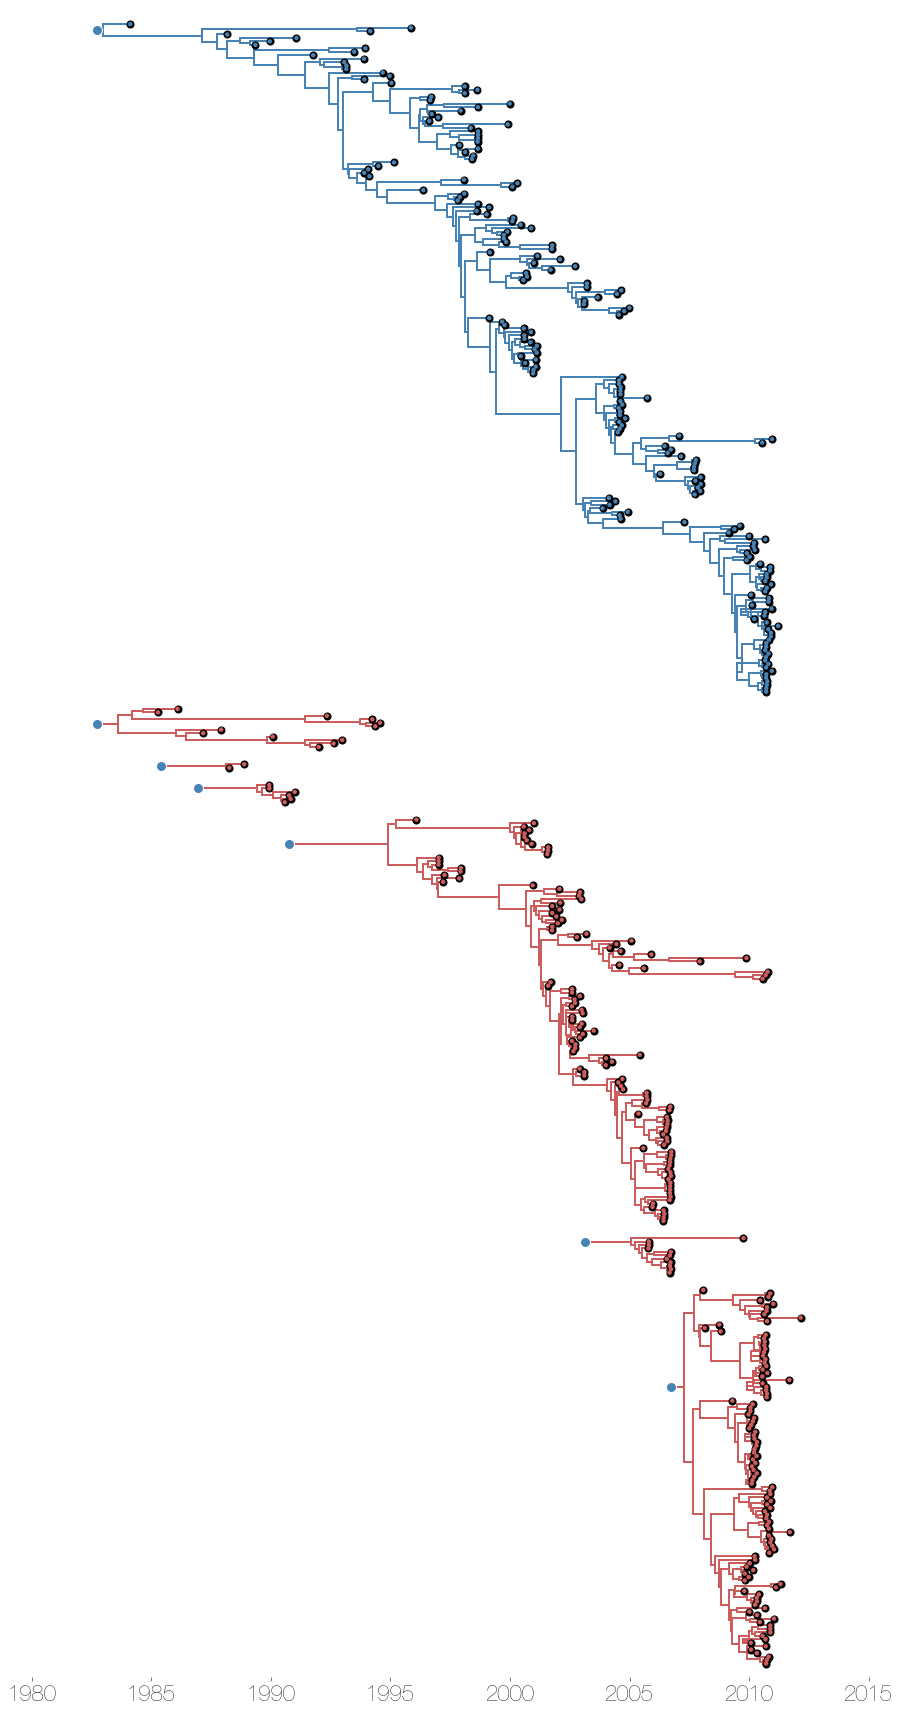

In [7]:
fig,ax = plt.subplots(figsize=(15,30),facecolor='w')

traitName='PB1'
branchWidth=2
tipSize=20

cumulative_y=0
for subtype in ['V','Y']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        if len([ob for ob in loc_tree.Objects if isinstance(ob,leaf)])>0: ## proceed only if there's at least one tip in subtree
            for w in loc_tree.Objects: ## iterate over subtree
                c=['indianred' if w.traits[traitName]=='V' else 'steelblue'][0] ## get colour

                y=w.y
                x=w.absoluteTime

                if y!=None:

                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y

                    if isinstance(w,leaf): ## if leaf - plot tip circle
                        ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                        ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=99)

                    elif isinstance(w,node): ## if node - plot vertical bar
                        yl=w.children[0].y
                        yr=w.children[-1].y
                        
                        ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                        
                    ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot branch
                    
                    

            oriC=['indianred' if origin=='V' else 'steelblue'][0]
            if loc_tree.Objects[0].absoluteTime==None:
                oriX=loc_tree.Objects[0].absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y
            else:
                oriX=loc_tree.Objects[0].parent.absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y

            ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin

            cumulative_y+=max([x.y for x in loc_tree.Objects])+5 ## increment y displacement

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.set_ylim(-5,cumulative_y)

plt.show()

## Tree transformations
------
This next bit plots the tree in terms of the trait transitions that take place within it. Trait space is where things get plotted, but other dimensions, such as time, can be represented with colour or line width, as desired. I've also added code to do Bezier curves, which I think are an amazing tool in a scientist's arsenal, mostly because they can be customised to prevent overlapping with each other and to highlight links between closely positioned points.

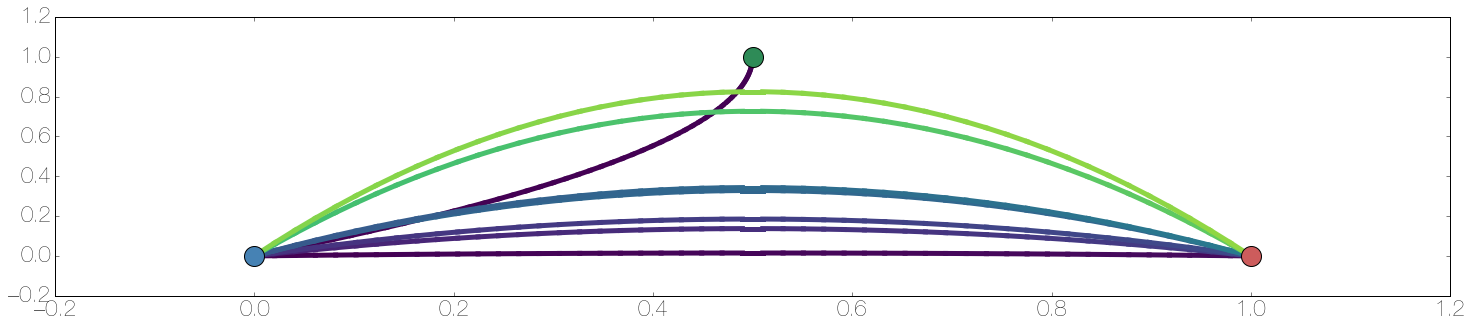

In [8]:
from scipy.special import binom

def Bernstein(n, k):
    """Bernstein polynomial.
    """
    coeff = binom(n, k)

    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)

    return _bpoly

def Bezier(points,start,end,num=10):
    """Build Bézier curve from points.
    """
    N = len(points)
    t = np.linspace(start, end, num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
        
    return curve

def Bezier_control(pointA,pointB,height):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance that defines a line perpendicular to line AB which intercepts AB at its midpoint.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB
    
    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2)
        
    h=np.sqrt(height**2+(d**2)/4.0)
    
    n1=x1+h*np.cos(np.arctan(2*height/float(d))+np.arctan(slope))*sign
    n2=y1+h*np.sin(np.arctan(2*height/float(d))+np.arctan(slope))*sign

    return (n1,n2)

fig,ax = plt.subplots(figsize=(25,5),facecolor='w')

coords={'V':(1,0),'Y':(0,0),'ancestor':(0.5,1)} ## coordinates for trait values

## plot traits as points
ax.scatter(coords['V'][0],coords['V'][1],s=400,facecolor='indianred',zorder=99999999)
ax.scatter(coords['Y'][0],coords['Y'][1],s=400,facecolor='steelblue',zorder=99999999)
ax.scatter(coords['ancestor'][0],coords['ancestor'][1],s=400,facecolor='seagreen',zorder=99999999)

for k in ll.Objects: ## iterate over objects in tree
    ct=k.traits[traitName] ## fetch current and parent traits
    pt=k.parent.traits[traitName]
    if ct!=pt: ## if they don't match - a switch happened
        
        P1=coords[pt] ## fetch coordinates of points
        P2=coords[ct]
        
        begin=k.parent.height ## fetch heights of node and its parent
        end=k.height
        
        mid_frac=(end+begin)/2.0/ll.treeHeight ## calculate the fractional height of middle of transitioning branch in tree
        
        if pt!='ancestor':
            control=Bezier_control(P1,P2,mid_frac*2) ## if dealing with a regular transition - control point is positioned according to fractional height of transition
        else:
            control=(0.5,0.5) ## if dealing with transition from ancestral state to regular states position control point in the middle
        curve=Bezier([P1,control,P2],0.0,1.0,num=50) ## get Bezier curve coordinates
        
        for f in range(len(curve)-1): ## iterate over segments of the line
            x1,y1=curve[f]
            x2,y2=curve[f+1]
            frac=f/float(len(curve)) 

            ax.plot([x1,x2],[y1,y2],lw=5,color=cmap((begin+(end-begin)*frac)/ll.treeHeight),zorder=int(mid_frac*10000)) ## plot each segment individually, colouring according to what fraction of the tree the segment traversed in time

plt.show()

## Sequential tanglegrams
-------
The following code imports a bunch of trees, collapses nodes, plots them end to end coloured by the trait value of the first tree and connects the same tips by lines that follow the order of tips in the first tree.

In [9]:
tree_base='/Users/evogytis/Documents/fluB/data/mcc trees/'

tree_paths=['InfB_PB1t_ALLs1.mcc.tre','InfB_PB2t_ALLs1.mcc.tre',
            'InfB_PAt_ALLs1.mcc.tre','InfB_HAt_ALLs1.mcc.tre',
            'InfB_NPt_ALLs1.mcc.tre','InfB_NAt_ALLs1.mcc.tre',
            'InfB_M1t_ALLs1.mcc.tre','InfB_NS1t_ALLs1.mcc.tre'] ## define a whole list of tree files

trees={} ## dict 

for tree_path in tree_paths: ## iterate over tree files
    print "File: %s"%(tree_path)
    tipFlag=False ## used to keep track of where we are in FigTree format
    tips={} ## dictionary of tip code to full tip name

    for line in open(tree_base+tree_path,'r'): ## iterate through FigTree lines
        l=line.strip('\n') ## strip newline characters from each line

        cerberus=re.search('dimensions ntax=([0-9]+);',l.lower()) ## check how many tips there are supposed to be
        if cerberus is not None:
            tipNum=int(cerberus.group(1))

        cerberus=re.search('tree TREE([0-9]+) = \[&R\]',l) ## search for beginning of tree string in BEAST format
        if cerberus is not None:
            treeString_start=l.index('(') ## tree string starts where the first '(' is in the line
            ll=tree() ## new instance of tree
            make_tree(l[treeString_start:],ll) ## send tree string to make_tree function, provide an empty tree object

        if tipFlag==True:
            cerberus=re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',l) ## look for tip name map, where each tip is given an integer to represent it in tree
            if cerberus is not None:
                tips[cerberus.group(1)]=cerberus.group(2).strip("'") ## if you give tips an integer (in the form of a string), it will return the full name of the tip
            elif ';' not in l: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
                print 'tip not captured by regex:',l.replace('\t','')

        if 'translate' in l.lower(): ## start looking for tips
            tipFlag=True
        if ';' in l: ## stop looking for tips
            tipFlag=False

    print "Number of objects found in tree string: %d"%(len(ll.Objects))

    ## rename tips, find the highest tip (in absolute time) in the tree
    if len(tips)==0: ## use this if tip names in the string are already the final format
        for k in ll.Objects:
            if isinstance(k,leaf):
                k.name=k.numName
        highestTip=max([decimalDate(x.name.strip("'").split('_')[-1],variable=True) for x in ll.Objects if isinstance(x,leaf)])
    else: ## there's a tip name map at the beginning, so translate the names
        ll.renameTips(tips) ## give each tip a name
        highestTip=max([decimalDate(x.strip("'").split('_')[-1],variable=True) for x in tips.values()])

    ll.treeStats() ## report tree stats (also traverses tree), otherwise need to call ll.traverse_tree()
    ll.sortBranches() ## sort the branches, automatically draws tree, otherwise need to call ll.drawTree()

    ## set absolute time knowing *when* the most recent tip is in absolute time
    ll.setAbsoluteTime(highestTip)
    print 'Highest tip date: %.4f'%(highestTip)

    cc=ll.collapseNodes('posterior',0.7) ## collapse nodes for clarity
    
    cc.sortBranches() ## sort branches, redraws tree too
    trees[tree_path.split('_')[1]]=cc ## add tree object to dict

    print 'Done!'

File: InfB_PB1t_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 28.071359
Tree length: 481.049928

Tree is strictly bifurcating = True

Tree has annotations = True

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Highest tip date: 2012.1530
Done!
File: InfB_PB2t_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 30.210110
Tree length: 484.851289

Tree is strictly bifurcating = True

Tree has annotations = True

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Highest tip date: 2012.1530
Done!
File: InfB_PAt_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 29.500153
Tree length: 458.766950

Tree is strictly bifurcating = True

Tree has annotations = True

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Highest tip date: 2012.1530
Done!
File: InfB_HAt_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 30.415856
Tree length: 449.376345

Tree is strictly bifurcating =

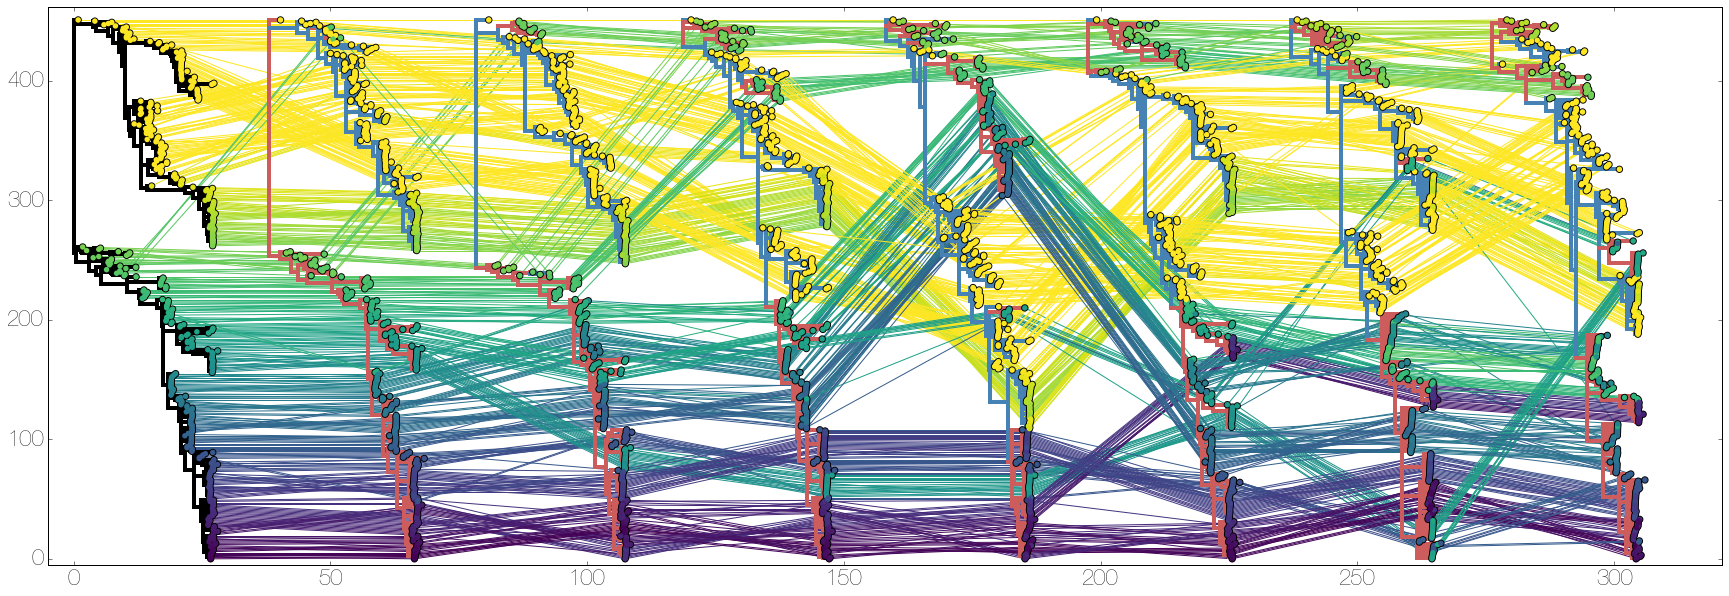

In [10]:
fig,ax = plt.subplots(figsize=(30,10),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

branchWidth=4 ## increase branch width, since trees will be smaller

tree_names=['PB1t','PB2t','HAt','PAt','NPt','NAt','M1t','NS1t'] ## define order in which dict will be accessed

tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

for tr in tree_names: ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,leaf): ## only interested in leaves
            tip_positions[tr][k.name]=(k.height,k.y) ## remember tree, tip's position

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    
    for k in cur_tree.Objects: ## iterate over branches
    #     x=k.x ## or from x position determined earlier
        x=k.height ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

    #     xp=k.parent.x ## get x position of current object's parent
        xp=k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent
    #     c='indianred' ## colour can be fixed
    #     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
    #     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
        if k.traits.has_key(traitName):
            c=['indianred' if k.traits[traitName]=='V' else 'steelblue'][0] ## can be discrete too
        else:
            c='k'
        if isinstance(k,leaf): ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name

            s=30 ## tip size can be fixed
            
            pos_in_first_tree=tip_positions['PB1t'][k.name][1] ## fetch y coordinate of same tip in the first tree
            frac_pos=pos_in_first_tree/float(len(cur_tree.Objects))*2.0 ## normalize coordinate to be within interval [0.0,1.0]
            
            ax.scatter(x,y,s=s,facecolor=cmap(frac_pos),edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                next_x+=cumulative_displace+cur_tree.treeHeight+10 ## adjust x coordinate by current displacement and future displacement
                
                ax.plot([x,next_x],[y,next_y],lw=1,ls='-',color=cmap(frac_pos),zorder=0) ## connect current tip with same tip in the next tree
            
        elif isinstance(k,node): ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot vertical bar

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9) ## always plot branch
        
    cumulative_displace+=cur_tree.treeHeight+10 ## increment displacement by the height of the tree

ax.set_ylim(-5,len([x for x in cur_tree.Objects if isinstance(x,leaf)])+10) ## set y limits
ax.set_xlim(-5,cumulative_displace+5)
plt.show()